# Q-Learning on FrozenLake-v0 and CliffWalking 

My implementation of Q-learning on OpenAI Gym's slippery and non-slippery Frozenlake, as well as the CliffWalking environments.

In [ ]:
!git clone https://github.com/henritomas/cs295-rl

Cloning into 'cs295-rl'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 29 (delta 3), reused 23 (delta 1), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [ ]:
%cd /content/cs295-rl

/content/cs295-rl


# Q-Learning

Q-Learning is an off-policy, TD learning algorithm which learns a table of state-action values to be used for selecting the next action. This table is called a Q-table, and is updated by considering the next episode's maximum state-action value given the next state. The formula goes:

$
Q(s,a) = Q(s,a) + \alpha[r + \gamma \times max(Q(s', A)) - Q(s,a)]
$

In [ ]:
import sys
import os
if "./" not in sys.path:
  sys.path.append("./") 

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import itertools
from collections import defaultdict
from lib import plotting
from tqdm import tqdm

matplotlib.style.use('ggplot')

## Epsilon-greedy Policy
For this experiment we will use the epsilon greedy policy. Given a state `s`, it simply gives the greedy action (w/ max action-value) a $(1-\epsilon)$ chance of being selected, while giving a cumulative $(\epsilon)$ chance of selecting one of the other actions.

In [ ]:
class EgreedyPolicy():
    '''
    Creates an egreedy policy object, list of probabilities for each action
    in the form of a numpy array.
    '''

    def __init__(self, Q, epsilon, nA):
        '''
        Args:
            Q: Dictionary that maps state -> action values. Each value is an np 
            array of length nA.
            epsilon: Probability that model chooses a random action.
            nA: Number of actions in the environment. (no. of Actions)
        '''

        self.Q = Q
        self.epsilon = epsilon
        self.nA = nA

    def step(self, state):
        '''
        Returns 1D numpy array of action probabilities when given state.
        e.g. if nA = 3, and best action is #3, 
        out would be [e/(nA-1), e/(nA-1), 1-e]
        '''
        Q, epsilon, nA = self.Q, self.epsilon, self.nA

        pA = np.ones(nA) * (epsilon/(nA-1))
        bestA = np.argmax(Q[state])
        pA[bestA] = (1 - epsilon)

        # Choose action greedily(1-epsilon)
        a = np.random.choice(np.arange(nA), p=pA)

        return a

## Q-learning Implementation
Now that we've defined the policy for selecting an action given the q-table, we implement the q-learning algorithm.

___
### Algorithm

1. Initialize the Q-table
2. Initiatialize / Reset environment to initial state `s`
3. Obtain action `a` using the egreedy policy on current state.
4. Agent performs the action, obtain next state and reward `s_prime, r`
5. Update Q-table value using the q-learning update formula. Update state `s=s_prime`.
5. Loop through (3,4,5) until episode is `done`
6. Loop through (2,3,4,5) until desired number of episodes or target reward is reached.

___
### Tunable Hyperparameters

- `n_episodes`: number of episodes to train the agent.
- `e_initial, e_final, e_decay`: desired initial and final values of epsilon, and decay factor to be used.
- `alpha`: TD learning rate
- `gamma`: future rewards discount factor


In [ ]:
def q_learning(env, n_episodes, e_initial, e_final, e_decay, alpha=0.1, gamma=1.0):
    '''
    Implementation of the Q-Learning algorithm: Off-policy TD control.
    Follows an epsilon-greedy policy with parameters set by arguments.

    Args:
        env: OpenAI gym environment
        n_episodes: number of training eps
        alpha: learning rate for Q update
        gamma: discount factor for future reward estimates

    Returns:
        (Q, stats): Tuple of new state-action dictionary and training stats
    '''

    # number of Actions in env
    nA = env.action_space.n

    # initialize Q(S,A) : state-action -> action-value function
    Q = defaultdict(lambda: np.zeros(nA))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))
    
    epsilon = e_initial
    for episode in tqdm(range(n_episodes)):

        #Make/update the policy
        policy = EgreedyPolicy(Q, epsilon, nA)

        # init total rewards per episode for statistics
        total_r = 0

        # Initilize environment, Get observation s
        s = env.reset()

        # Decaying epsilon
        if epsilon > e_final:
            epsilon *= e_decay

        for t in itertools.count(): # Counts timesteps t for each episode
            
            # Get action given state s, choose action egreedily
            a = policy.step(s)

            # Perform action, observe R, S'
            s_prime, r, done, _ = env.step(a)

            # Q-Update
            Q[s][a] = Q[s][a] + alpha * (r + (gamma * np.max(Q[s_prime])) - Q[s][a])

            # state update
            s = s_prime

            total_r += r
            if done: 
                break

        stats.episode_lengths[episode] = t
        stats.episode_rewards[episode] = total_r
            
    return Q, stats

def q_learning_frozenlake(env, n_episodes, e_initial, e_final, e_decay, alpha=0.1, gamma=1.0):
    '''
    Implementation of the Q-Learning algorithm: Off-policy TD control.
    Follows an epsilon-greedy policy with parameters set by arguments.

    Args:
        env: OpenAI gym environment
        n_episodes: number of training eps
        alpha: learning rate for Q update
        gamma: discount factor for future reward estimates

    Returns:
        (Q, stats): Tuple of new state-action dictionary and training stats
    '''

    # number of Actions in env
    nA = env.action_space.n

    # initialize Q(S,A) : state-action -> action-value function
    Q = defaultdict(lambda: np.zeros(nA))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))
    
    epsilon = e_initial
    for episode in tqdm(range(n_episodes)):

        #Make/update the policy
        policy = EgreedyPolicy(Q, epsilon, nA)

        # init total rewards per episode for statistics
        total_r = 0

        # Reset environment, Get observation s
        s = env.reset()

        # Decaying epsilon
        if epsilon > e_final:
            epsilon *= e_decay

        for t in itertools.count(): # Counts timesteps t for each episode
            
            # Get action given state s, choose action egreedily
            a = policy.step(s)

            # Perform action, observe R, S'
            s_prime, r, done, _ = env.step(a)

            # Since Frozenlake-v0 env returns r > 0 only when agent gets to goal
            if done:
                rr = 1 if r > 0 else -1
            else:
                rr = 0


            # Q-Update
            Q[s][a] = Q[s][a] + alpha * (rr + (gamma * np.max(Q[s_prime])) - Q[s][a])

            # state update
            s = s_prime

            total_r += r
            if done: 
                break

        stats.episode_lengths[episode] = t
        stats.episode_rewards[episode] = total_r
            
    return Q, stats

## Evaluation of Deterministic FrozenLake

100%|██████████| 1000/1000 [00:00<00:00, 1144.85it/s]


Avg. reward for best 100 eps: 1.0


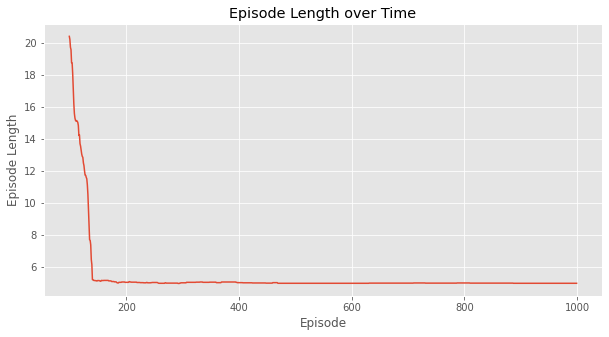

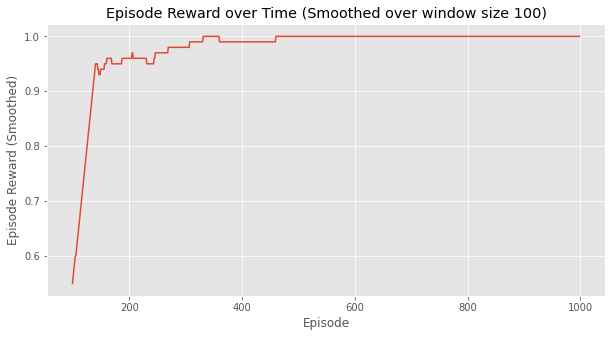

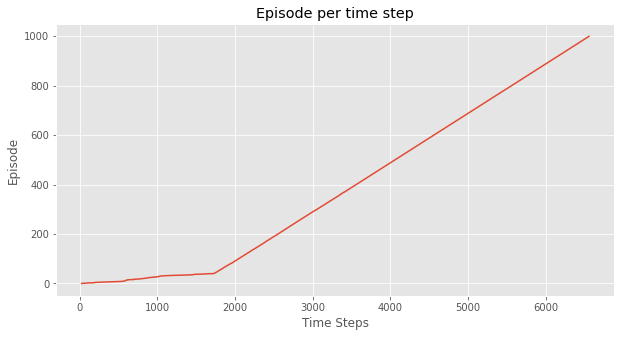

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
env = gym.make('FrozenLake-v0', is_slippery=False)
num_epi = 1000
Q, stats = q_learning_frozenlake(env, num_epi, 0.1, 0.001, 0.99, 0.5)

best_hundred = -np.inf
#Get an idea about the avg of the best hundred episodes before submitting on gym
for i in range(num_epi - 100):
    best_hundred = max(best_hundred, np.sum(stats.episode_rewards[i : i + 100]))
print("Avg. reward for best 100 eps:", best_hundred / 100.)

plotting.plot_episode_stats(stats, smoothing_window=100)

## Evaluation of Stochastic FrozenLake

100%|██████████| 1000/1000 [00:04<00:00, 218.00it/s]


Avg. reward for best 100 eps: 0.85


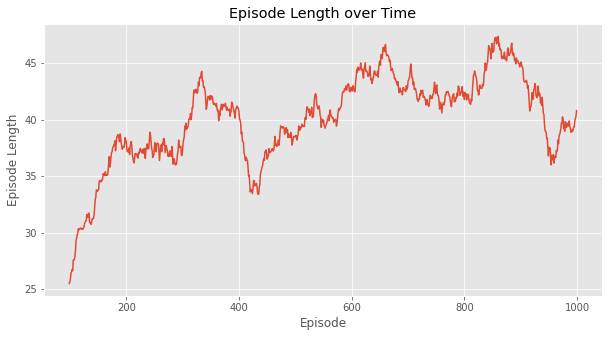

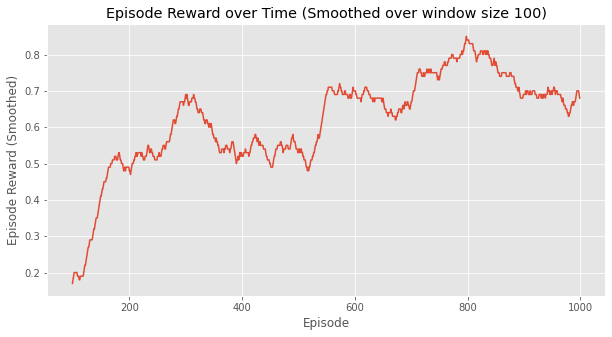

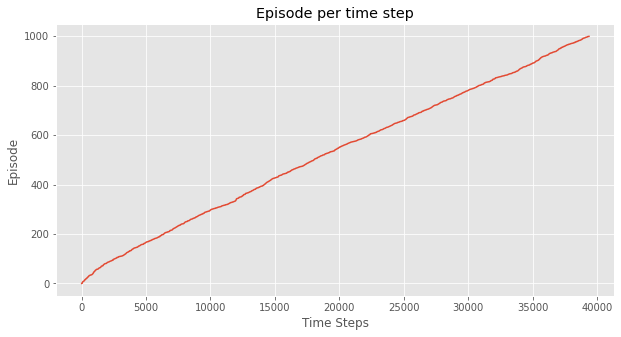

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
env = gym.make('FrozenLake-v0', is_slippery=True)
num_epi = 1000
Q, stats = q_learning_frozenlake(env, num_epi, 0.1, 0.001, 0.99, 0.5)

best_hundred = -np.inf
for i in range(num_epi - 100):
    best_hundred = max(best_hundred, np.sum(stats.episode_rewards[i : i + 100]))
print("Avg. reward for best 100 eps:", best_hundred / 100.)

plotting.plot_episode_stats(stats, smoothing_window=100)

## Evaluation on CliffWalking Environment

100%|██████████| 500/500 [00:00<00:00, 686.10it/s]


Avg. reward for best 100 eps: -44.49


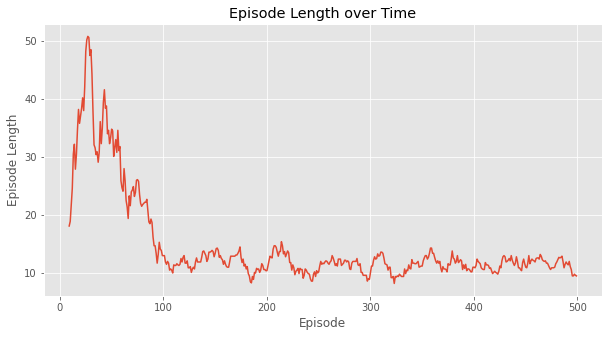

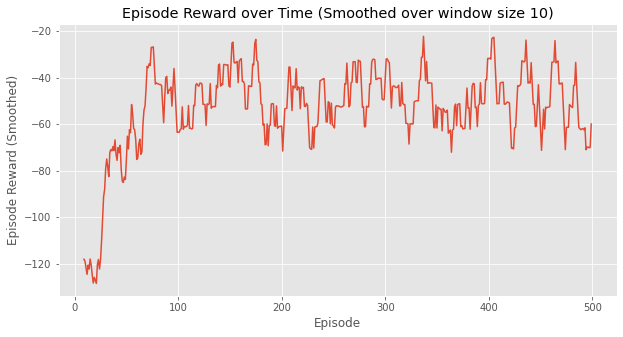

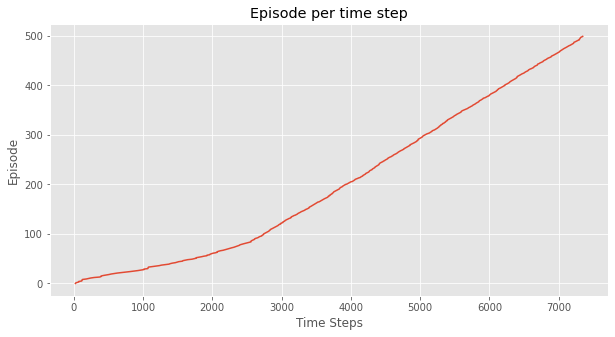

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
from lib.envs import CliffWalkingEnv

env = CliffWalkingEnv(4,12)
num_epi = 500
Q, stats = q_learning(env, num_epi, 0.1, 0.1, 1.0, 0.5)

# mean reward of best consecutive 100 episodes:
best_hundred = -np.inf
for i in range(num_epi - 100):
    best_hundred = max(best_hundred, np.sum(stats.episode_rewards[i : i + 100]))
print("Avg. reward for best 100 eps:", best_hundred / 100.)

plotting.plot_episode_stats(stats, smoothing_window=10)